In [1]:
# Nature Scientific Data Paper
# Author: Kelsey Montgomery
# Date: 20190604

In [3]:
# Dependencies
suppressMessages({library(CovariateAnalysis)
                  library(variancePartition)
                  library(BiocParallel)
                  library(data.table)
                  library(tidyverse)
                  library(synapser)
                  library(spatstat)
                  library(ggrepel)
                  library(cowplot)
                  library(biomaRt)
                  library(foreach)
                  library(future)
                  library(limma)
                  library(edgeR)
                  })

In [4]:
feature = 'genes'

In [5]:
# Directory for figure output
if(!dir.exists(feature)){
    dir.create(feature, recursive=TRUE)
}

# Process functions
downloadFile_version <- function(id , version){
  fread(synGet(id, version = version)$path, data.table = F)
}

In [6]:
# Login to Synapse with apikey - 
# https://r-docs.synapse.org/articles/manageSynapseCredentials.html
synLogin()

Welcome, kj.benjamin!

NULL

In [7]:
param = SnowParam((availableCores()-2)/2, "SOCK", progressbar=TRUE)
register(param)

## Download metadata

In [8]:
# Download clinical metadata 
CLINICAL_ID = 'syn3354385'
clinical = downloadFile_version(CLINICAL_ID, version = 4)

# Download RNASeq metadata
METADATA_QC_DLPFC_ID = 'syn18358379' 
metadata = downloadFile_version(METADATA_QC_DLPFC_ID, version = 3)

# Join clinical and RNASeq metadata 
md = right_join(clinical, metadata, by = c("Individual ID" = "Individual_ID")) %>% 
    mutate(Dx = fct_recode(Dx, AFF_BP = "BP", AFF_BP = "AFF", Other = "undetermined", 
                           Control = "Control", SCZ = "SCZ")) %>%
    filter(Dx %in% c("Control", "SCZ"), Sex %in% c('XX', 'XY'))

# Compute read pair metrics and add Institution-Dx variable
md <- md %>%
  mutate(MappedRead_Pairs = Mapped_Reads/2) %>%
  mutate(`Institution-Dx` = paste0(`Institution`, "-", `Dx`)) %>% 
  mutate(TotalRead_Pairs = Total_Reads/2)

# Add MDS from SNPs
mds_file = paste0('/ceph/users/jbenja13/projects/sex_sz_ria/input/commonMind/',
                  'genotypes/mds/_m/CMC_MSSM-Penn-Pitt_DLPFC_QC.mds')
mds = fread(mds_file, data.table=F)
colnames(mds) = gsub('C', 'snpPC', colnames(mds))

pheno_file = paste0('/ceph/users/jbenja13/projects/sex_sz_ria/input/commonMind/', 
                    'phenotypes/combine_files/_m/CMC_phenotypes_all.csv')
pheno = read.csv(pheno_file, stringsAsFactors = F) 
genotypes = merge(pheno, mds, by.y='IID', by.x='Genotypes.Genotyping_Sample_ID') 

genotypes = genotypes %>% 
    dplyr::select("Individual_ID", starts_with("snpPC")) %>%
    rename("Individual ID"=Individual_ID)

md = md %>% left_join(genotypes, by="Individual ID") %>% distinct

md %>% dim

[1] 858  65

In [9]:
unique(md$Brain_Region)

[1] "DLPFC"

## Define covariate relationships

In [10]:
# Covariate relationships
FactorCovariates <- c('Individual ID', "Institution", "Reported Gender", "Library_Batch", 
                      "Ribozero_Batch", "Flowcell_Batch", "Dx")
ContCovariates <- c("Age of Death", "PMI (in hours)", "RIN", "Mapped_Reads", 
                    "MappedRead_Pairs", "Intragenic_Rate", "Intronic_Rate", 
                    "Intergenic_Rate", "Genes_Detected", "Expression_Profiling_Efficiency",
                    "rRNA_Rate", "Total_Reads","Percent_Aligned", "snpPC1", "snpPC2", 
                    "snpPC3", "snpPC4", "snpPC5")
# Ages over 90
md <- mutate(md, `Age of Death` = ifelse(`Age of Death` == "90+", "90", `Age of Death`))

# Find inter relation between factor covariates
covariates = md[,c(FactorCovariates,ContCovariates),drop=F]
covariates[,FactorCovariates] <- data.frame(lapply(covariates[,FactorCovariates],
                                                   function(x){
  x <- sapply(x,function(y){str_replace_all(as.character(y),'[^[:alnum:]]','_')})}))
rownames(covariates) <- md$SampleID

# Convert factor covariates to factors
covariates[,FactorCovariates] = lapply(covariates[,FactorCovariates], factor)
covariates[,ContCovariates] = lapply(covariates[,ContCovariates], function(x){
  x = as.numeric(as.character(gsub('[\\,\\%]','',x)))
})

# Remove spaces
colnames(covariates) <- gsub(' ', '_', colnames(covariates))
covariates %>% dim

[1] 858  25

## Download counts

In [11]:
# Download counts (DLPFC - MSSM)
COUNT_ID = 'syn17346208'
count = downloadFile_version(COUNT_ID, version = 2) %>% data.frame()
count$transcript_id.s. = NULL

# Download gene lengths (DLPFC - MSSM)
genelen_CMC = downloadFile_version('syn17346397', version = 2) %>%
  gather(sampleID, Length, -gene_id, -`transcript_id(s)`) %>%
  group_by(gene_id) %>%
  summarise(Length = median(Length, na.rm = T)) %>%
  ungroup() %>% data.frame()

# Download counts (DLPFC - HBCC)
COUNT_ID = 'syn17894685'
count_HBCC = downloadFile_version(COUNT_ID, version = 4) %>% data.frame()
count_HBCC$transcript_id.s. = NULL

# Join HBCC and MSSM counts
count = full_join(count, count_HBCC, by = c("gene_id"))
count[1:2, 1:5]

`summarise()` ungrouping output (override with `.groups` argument)



,gene_id,MSSM_RNA_BP_PFC_2,MSSM_RNA_BP_PFC_4,MSSM_RNA_BP_PFC_5,MSSM_RNA_BP_PFC_6
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000003.14,159,113,175,117
2,ENSG00000000005.5,2,1,1,2


In [12]:
NEW.COUNTS = count %>% column_to_rownames(var='gene_id') %>% t %>%
    as.data.frame %>% rownames_to_column %>% 
    filter(rowname %in% md$SampleID) %>% 
    column_to_rownames(var="rowname") %>% t %>%
    as.data.frame
NEW.COUNTS[1:2, 1:5]

,MSSM_RNA_PFC_1,MSSM_RNA_PFC_2,MSSM_RNA_PFC_3,MSSM_RNA_PFC_4,MSSM_RNA_PFC_5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000003.14,124,103,160,366,268
ENSG00000000005.5,1,0,1,4,2


## Voom with DREAM

In [13]:
# Set covariates to adjust for from model selection
adjust.covars <- c("Dx", "Reported_Gender", "RIN", "Intronic_Rate")

writeLines(paste('Using following covariates in the model:',
                 paste(adjust.covars, collapse=', '),
                 'as fixed effects and Individual_ID is chosen as random effect'))
# Post adjusted formula
random_effect <- "Individual_ID"
formula <- paste("~", glue::glue_collapse(adjust.covars[1:2], sep='*'), "+",
      glue::glue_collapse(adjust.covars[3:4], sep=" + ")) %>% 
  glue::glue(" + (1|{random_effect})")
formula

Using following covariates in the model: Dx, Reported_Gender, RIN, Intronic_Rate as fixed effects and Individual_ID is chosen as random effect


~ Dx*Reported_Gender + RIN + Intronic_Rate + (1|Individual_ID)

In [14]:
# Estimate voom weights with DREAM
geneExpr = DGEList(NEW.COUNTS, samples=covariates)

design0 <- model.matrix(~Dx*Reported_Gender, data=geneExpr$samples)
keep.x <- filterByExpr(geneExpr, design=design0)
geneExpr <- geneExpr[keep.x, , keep.lib.sizes=FALSE]
print(paste('There are:', sum(keep.x), 'features left!', sep=' '))

geneExpr = calcNormFactors(geneExpr)

[1] "There are: 22684 features left!"


In [16]:
VOOM.GENE_EXPRESSION = voomWithDreamWeights(counts = geneExpr, 
                                            formula = formula,
                                            data = covariates,
                                            save.plot = TRUE)

Memory usage to store result: > 1.7 Gb 
Dividing work into 100 chunks...


iteration: 
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100





Total: 289 s


Warning message in regularize.values(x, y, ties, missing(ties)):
"collapsing to unique 'x' values"


In [17]:
save(VOOM.GENE_EXPRESSION, file=paste0(feature,'/voom.RData'))

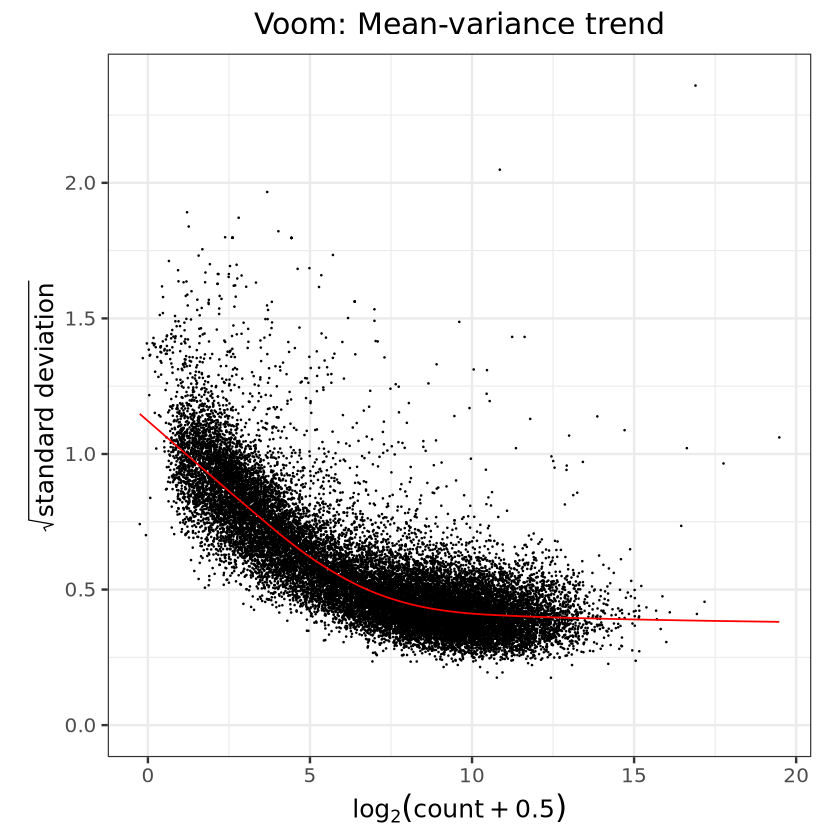

In [17]:
# How to plot a voom object if save.plot=TRUE
# Set plot generic to voom result EList
#' @export
setMethod("plot", signature(x="EList", y="missing"),
  function(x,  y, ...){
    if( is.null(x$voom.xy) || is.null(x$voom.line)){
        stop("x does not contain the trend information.\nvoom() must be run with save.plot=TRUE")
    }
    # points
    df = data.frame(x = x$voom.xy$x,
                    y = x$voom.xy$y)
    # trend line
    df.line = data.frame(x = x$voom.line$x,
                        y = x$voom.line$y)
    ggplot(df, aes(x,y)) + geom_point(size=.1) + theme_bw(15) + 
      theme(aspect.ratio=1, plot.title = element_text(hjust = 0.5)) + 
      geom_line(data=df.line, aes(x,y), color="red") + xlab(bquote(log[2](count + 0.5))) + 
      ylab(expression( sqrt("standard deviation"))) + ggtitle("Voom: Mean-variance trend") + 
      ylim(0, max(df$y))
  }
)
plot(VOOM.GENE_EXPRESSION)

In [22]:
# Fit linear model using new weights and new design
ADJUSTED.FIT = dream(exprObj = VOOM.GENE_EXPRESSION,
                     formula = formula,
                     data = covariates)

Dividing work into 100 chunks...


iteration: 
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100





Total: 465 s


In [23]:
# Get background genes 
backgroundGenes = data.frame(gene_id = rownames(NEW.COUNTS)) %>%
  mutate(id = gene_id) %>%
  separate(id, c('ensembl_gene_id','position'), sep = '\\.')

# Define biomart object
mart <- biomaRt::useMart(biomart = "ENSEMBL_MART_ENSEMBL",
                host = "uswest.ensembl.org", # Ensembl Release 99 (January 2020)
                dataset = "hsapiens_gene_ensembl")
# Query biomart
Ensemble2HGNC <- getBM(attributes = c("ensembl_gene_id", "hgnc_symbol", 
                                      "percentage_gene_gc_content", "gene_biotype", 
                                      "chromosome_name"),
                       filters = "ensembl_gene_id", 
                       values = backgroundGenes$ensembl_gene_id,
                       mart = mart)


Batch submitting query [>------------------------------]   2% eta: 26s

Batch submitting query [>------------------------------]   3% eta: 34s

Batch submitting query [>------------------------------]   3% eta: 38s

Batch submitting query [>------------------------------]   4% eta: 43s

Batch submitting query [=>-----------------------------]   5% eta: 44s

Batch submitting query [=>-----------------------------]   6% eta: 46s

Batch submitting query [=>-----------------------------]   7% eta: 46s

Batch submitting query [=>-----------------------------]   8% eta: 47s

Batch submitting query [==>----------------------------]   9% eta: 47s

Batch submitting query [==>----------------------------]   9% eta:  1m

Batch submitting query [==>----------------------------]  10% eta:  1m

Batch submitting query [==>----------------------------]  11% eta:  1m

Batch submitting query [===>---------------------------]  12% eta:  1m

Batch submitting query [===>---------------------------]  13% e

In [24]:
colnames(ADJUSTED.FIT$design)

[1] "(Intercept)"               "DxSCZ"                    
[3] "Reported_GenderMale"       "RIN"                      
[5] "Intronic_Rate"             "DxSCZ:Reported_GenderMale"

### Calculate differential expression with eBayes

#### SZ vs Ctrl

In [43]:
extract_de <- function(coef_name, comparison){
    top <- topTable(ADJUSTED.FIT, coef=coef_name, number = Inf, sort.by="P") %>%
        rownameToFirstColumn('gene_id') %>% 
        left_join(backgroundGenes) %>% 
        mutate(Direction = logFC/abs(logFC),
               Direction = factor(Direction, c(-1,1), c('-1' = 'DOWN', '1' = 'UP')),
               Direction = as.character(Direction)) %>%
        left_join(Ensemble2HGNC)
    top.fdr <- top %>% filter(adj.P.Val<=0.05)
    print(dim(top.fdr)[1])
    write.table(top, 
                file=paste0(feature, "/diffExpr_", comparison, "_full.txt"),
                sep='\t', row.names=FALSE, quote=FALSE)
    write.table(top.fdr, 
                file=paste0(feature, "/diffExpr_", comparison, "_FDR05.txt"),
            sep='\t', row.names=FALSE, quote=FALSE)
}

In [44]:
options(width=200)

extract_de("DxSCZ", "szVctl")

Joining, by = "gene_id"

Warning message:
"Column `gene_id` joining character vector and factor, coercing into character vector"
Joining, by = "ensembl_gene_id"



[1] 2183


#### Male vs Female

In [45]:
extract_de("Reported_GenderMale", "maleVfemale")

Joining, by = "gene_id"

Warning message:
"Column `gene_id` joining character vector and factor, coercing into character vector"
Joining, by = "ensembl_gene_id"



[1] 202


#### Interaction

In [46]:
extract_de("DxSCZ:Reported_GenderMale", "interaction")

Joining, by = "gene_id"

Warning message:
"Column `gene_id` joining character vector and factor, coercing into character vector"
Joining, by = "ensembl_gene_id"



[1] 1


### Calculate residuals

In [56]:
null_model = ADJUSTED.FIT$design %>% as.data.frame %>%
    dplyr::select(!c("Reported_GenderMale", "DxSCZ", "DxSCZ:Reported_GenderMale"))
fit_res <- limma::lmFit(VOOM.GENE_EXPRESSION, design=null_model)
res = VOOM.GENE_EXPRESSION$E - ( fit_res$coefficients %*% t(null_model) )
res_sd = apply(res, 1, sd)
res_mean = apply(res, 1, mean)
## Normalize residuals and write to file
res_norm = (res - res_mean) / res_sd

In [23]:
write.table(res_norm, 
            file=paste0(feature, '/residualized_expression.tsv'), 
            sep="\t", quote=FALSE)

## Repreducibility Information

In [40]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2019-06-06 15:35:17 EDT"

    user   system  elapsed 
3161.182   47.897  287.152 

- Session info -------------------------------------------------------------------------------------------------------
 setting  value                       
 version  R version 3.5.0 (2018-04-23)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  C                           
 ctype    C                           
 tz       America/New_York            
 date     2019-06-06                  

- Packages -----------------------------------------------------------------------------------------------------------
 package              * version   date       lib source        
 annotate               1.60.0    2018-10-30 [1] Bioconductor  
 AnnotationDbi          1.44.0    2018-10-30 [1] Bioconductor  
 assertthat             0.2.0     2017-04-11 [1] CRAN (R 3.5.0)
 base64enc              0.1-3     2015-07-28 [1] CRAN (R 3.5.0)
 bindr                  0.1.1     2018-03-13 [1] CR